# The Landau-Zener model  
There, we will use example of a Landau-Zener transition to demonstrate two ways of implementing time dependent temrs.  

The **Landau-Zener model** describes the transition probability of a quantum system with two energy levels that cross each other as a function of an externel parameter. For example, one can consider two spins weakly coupled to each other ($g$) while an external magnetic field is swept. If the two spins have an energy spectrum that corss each other as a function of the magnetic field, an avoided crossing is created due to the interaction of the spins with each other  

If the magnetic field is swept slowly (adiabatically), no transition across the splitting occurs. However, if it is swept quickly (diabatically), the transition hops over the splitting, effectively ignoring the splitting. If swept at an intermediate rate, the transition probability is given by a well defined probability.

# Section 1 - Implementing time dependent terms  
we wil use ```ScalerOperator``` - a ```tensor callback``` function for custom operators  

We consider the following simple Hamiltonian representing the lowest two levels of the system. Note we consider first a small system as an instructional example to demonstrate the above features. A system this small won't experience a good acccleration run on GPU, but the features here can easily be scaled towards much larger system which will experience a significant GPU speed-up.
$$ \hat{H} = \begin{bmatrix} -\alpha t & g  \\ g  & \alpha t \end{bmatrix}$$
Here the coupling b/w levels is denoted by g and the time dependent parameter is denoted by $\alpha$. The above Hamiltonian can be of course decompsed into the following operators:
$$\hat{H} = g\hat{\sigma}_x - \alpha t \hat{\sigma}_z$$
We can implement the Pauli decompision easily by constructing our Hamiltonian in CUDA-Q Dynamics with our typical spin operators and by leveragin a ```ScalerOperator``` with a time dependence and multiplying that by the $\sigma_z$ term. The transition probability is known to be $P = e^{-\frac{\pi g^2}{\alpha}}$ but we will observe this by performing the following simulation.

In [1]:
import cudaq
from cudaq import spin, operators, ScalarOperator, Schedule, ScipyZvodeIntegrator
import numpy as np
import cupy as cp
import os
import matplotlib.pyplot as plt

In [20]:
# set target to dynamics simulator
cudaq.set_target('dynamics')

# Define some shorthand operators
sx = spin.x(0)
sz = spin.z(0)
sm = operators.annihilate(0)
sm_dag = operators.create(0)

# Dimensions of sub-system. We only have a single degree of freedom of dimensions 2 (two-level system)
dimensions = {0: 2}

Let's set a target transition probability 0.75 to inform our value of $\alpha$. We will see that computing the simulation will yield a transition result predicted by the theory

In [8]:
g = 2 * np.pi # coupling strength
target_p0 = 0.75
alpha = (-np.pi * g**2) / np.log(target_p0)

We define our Hamiltonian below and use the ```ScalerOperator``` to multiply the $\sigma_z$ term by $t$ in a lambda function. This functionality also enables the easy implementation of time dependent drive terms and envelop function by simply replacing the function in the ```ScalerOperator``` argument

In [11]:
hamil = g*sx - alpha * ScalarOperator(lambda t: t) * sz

In [ ]:
# Initial state (ground state)
psi0 = cudaq.State.from_data(cp.array([1.0, 0.0], dtype = cp.complex128))

# Schedule of time steps (simulating a long time range)
steps = np.linspace(-2.0, 2.0, 5000)
schedule = Schedule(steps, ["t"])

evolution_result = cudaq.evolve(hamil,
                                dimensions,
                                schedule,
                                psi0,
                                observables=[operators.number(0)],
                                collapse_operators = [],
                                store_intermediate_results = cudaq.IntermediateResultSave.EXPECTATION_VALUE,
                                integrator = ScipyZvodeIntegrator())

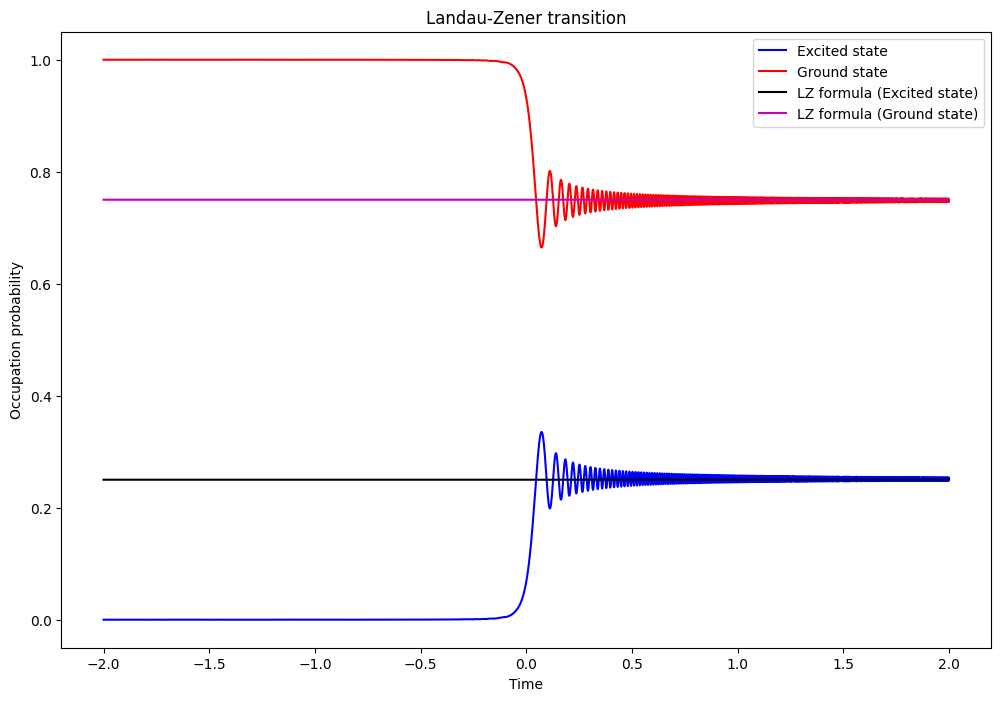

In [32]:
# Collect the results and plot
prob1 = [
    exp_vals[0].expectation()
    for exp_vals in evolution_result.expectation_values()
]

prob0 = [1 - val for val in prob1]
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(steps, prob1, 'b', steps, prob0, 'r')
ax.plot(steps, (1.0 - target_p0) * np.ones(np.shape(steps)), 'k')
ax.plot(steps, target_p0 * np.ones(np.shape(steps)), 'm')
ax.set_xlabel("Time")
ax.set_ylabel("Occupation probability")
ax.set_title("Landau-Zener transition")
ax.legend(("Excited state", "Ground state", "LZ formula (Excited state)",
           "LZ formula (Ground state)"),
          loc=0)
plt.show()